# Tutorial Part 15: Training a Generative Adversarial Network on MNIST


In this tutorial, we will train a Generative Adversarial Network (GAN) on the MNIST dataset.  This is a large collection of 28x28 pixel images of handwritten digits.  We will try to train a network to produce new images of handwritten digits.


This tutorial and the rest in the sequences are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/13_Training_a_Generative_Adversarial_Network_on_MNIST.ipynb)

Let's first run the commands to install DeepChem on this colab environment.

In [ ]:
!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

To begin, let's import all the libraries we'll need and load the dataset (which comes bundled with Tensorflow).

In [1]:
import deepchem as dc
import tensorflow as tf
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
images = mnist.train.images.reshape((-1, 28, 28, 1))
dataset = dc.data.NumpyDataset(images)

/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
RDKit WARNING: [18:23:54] Enabling RDKit 2019.09.3 jupyter extensions
/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Pas

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

Let's view some of the images to get an idea of what they look like.

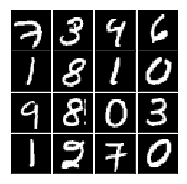

In [2]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images)

Now we can create our GAN.  It consists of two parts:

1. The generator takes random noise as its input and produces output that will hopefully resemble the training data.
2. The discriminator takes a set of samples as input (possibly training data, possibly created by the generator), and tries to determine which are which.  Its output is interpreted as a measure of how likely it is that each sample is from the training set.

In [3]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Now to train it.  The generator and discriminator are both trained together.  The generator tries to get better at fooling the discriminator, while the discriminator tries to get better at distinguishing real data from generated data (which in turn gives the generator a better training signal to learn from).

In [4]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)








Ending global_step 4999: generator average loss 0.558625, discriminator average loss 0.55266
Ending global_step 9999: generator average loss 0.536556, discriminator average loss 0.530595


KeyboardInterrupt: 

Let's generate some data and see how the results look.

In [ ]:
plot_digits(gan.predict_gan_generator(batch_size=16))

Not too bad.  Many of the generated images look plausibly like handwritten digits.  A larger model trained for a longer time can do much better, of course.